In [12]:
from qiskit import *
from scipy.optimize import minimize
import numpy as np
from pylab import *

In [3]:
#2^4 possible states of four qubits stored in dic
bit = ['0','1']
dic = []
for i in bit:
    for j in bit:
        for k in bit:
            for l in bit:
                dic.append(i+j+l+k)


In [18]:
def calcEJ(theta):
    #make quantum circuit with 2 qubits
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q,c)

    # entangled quantum state preparation
    q = circuit.qregs[0]
    circuit.u(theta[0], theta[1], 0, q[0])
    circuit.cx(q[0],q[1])
    circuit.cx(q[0],q[2])
    circuit.cx(q[0],q[3])
    for i in range(0,4):
        circuit.u(theta[i+2],0,0,q[i])
    circuit.measure(range(4),range(4))

    # Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    
    shots=18192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots = shots).result()
    counts = result.get_counts()

    #make sure that all possible values accounted for to avoid errors
    for i in dic:
        if i not in counts:
            counts[i] = 0
    
    #calculate expectation value in terms of sigma z of qubit i and qubit i+1
    def prob(i):
        t1=0
        t2=0
        for j in counts.keys():
            if j[i]=='0': t1+=counts[j]
            else: t1-=counts[j]
        t1=t1/shots

        for j in counts.keys():
            if j[i+1]=='0': t2+=counts[j]
            else: t2-=counts[j]
        t2=t2/shots
        E=-1*t1*t2
        return E
    E_J=0
    for i in range(0,3): E_J+=prob(i)
    return E_J

In [19]:
def calcEZ(theta):
    #make quantum circuit with 2 qubits
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q,c)

    # entangled quantum state preparation
    q = circuit.qregs[0]
    circuit.u(theta[0], theta[1], 0, q[0])
    circuit.cx(q[0],q[1])
    circuit.cx(q[0],q[2])
    circuit.cx(q[0],q[3])
    for i in range(0,4):
        circuit.u(theta[i+2],0,0,q[i])
    circuit.h(range(4))
    circuit.measure(range(4),range(4))

    # Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    
    shots=18192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots = shots).result()
    counts = result.get_counts()

    #make sure that all possible values accounted for to avoid errors
    for i in dic:
        if i not in counts:
            counts[i] = 0
    
    #calculate expectation value in terms of sigma x of qubit i 
    def prob(i):
        E=0
        for j in counts.keys():
            if j[i]=='0': E+=counts[j]
            else: E-=counts[j]
        E=E/shots
        return E
    E_Z=0
    for i in range(0,3): E_Z+=prob(i)
    return E_Z

In [20]:
# expectation value total 
def calcE(theta):
    # Summing the measurement results
    classical_adder = calcEJ(theta) + h * calcEZ(theta)
    return classical_adder

In [21]:
h=2
calcE(theta=[1.5708,0,1.10715,0,2.03444,0])

0.007408322755264088

In [54]:
theta0=[1.5708,0,1.10715,0,2.03444,0]
tol = 1e-3 # tolerance for optimization precision.
# Get expectation energy by optimization with corresponding h = 0.1, 0.2,..., 2.9, 3. 
y_vqe = []
for k in range(0,31):
    h=k/10
    vqe_result = minimize(calcE, theta0 , method="COBYLA", tol=tol)
    y_vqe.append(vqe_result.fun)
print(y_vqe)

[2.5961714737899807e-05, 0.00023117770846918512, -3.03226950976934, -3.08537829215815, -3.1282611587994453, -3.163805306187726, -3.304064337867013, -3.4528248086084985, -3.526828618453877, -3.7380168508449696, -3.925078709440743, -4.11347018492863, -4.259443798544055, -4.480238602662192, -4.7331274888437145, -4.851093684370525, -5.234256057153289, -5.39478828004075, -5.649619979961618, -5.854646847193892, -6.147648538234596, -6.43843264438581, -6.793989645481907, -6.982278011384864, -7.301223536455469, -7.65489531337385, -7.886088417574989, -8.198392341361837, -8.498415266957979, -8.77787458790008, -9.103520826709953]


Text(0, 0.5, 'E/N with N = 4')

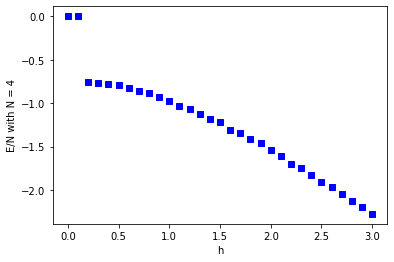

In [56]:
y_mean = np.array(y_vqe)/4

x2 = []
for k in range(0,31):
    x2.append(k/10)

plot(x2,y_mean,'bs', label='VQE')

plt.xlabel('h')
plt.ylabel('E/N with N = 4')